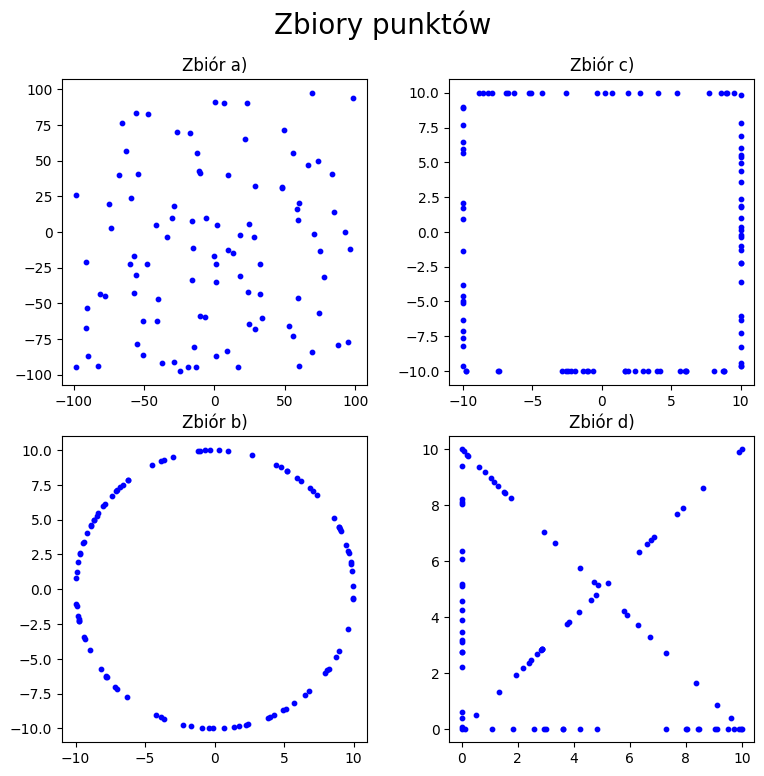

Generating data took: 0.002s.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import math
import time
from functools import *


# helper functions/setting up
np.random.seed(2)

def lerp(start, end, t):
    return start + (end - start) * t

data = []

# generating 1a
def generate_set_a(start, stop, count):
    return np.random.uniform(start, stop, [count, 2])

# generating 1b
def generate_set_b(center, radius, count):
    return np.array([[center[0] + radius*math.sin(angle),  center[1] + radius*math.cos(angle)]
                    for angle in np.random.uniform(0, 2*math.pi, count)])

# generating 1c
def generate_set_c(lower_left, upper_right, count):
    ll, ur, arr = lower_left, upper_right, [[] for _ in range(count)]
    for i in range(count):
        s = random.randint(0, 3)
        t = random.random()

        # lower side
        if s == 0:
            arr[i] = [lerp(ll[0], ur[0], t), ll[1]]
        
        # right side
        if s == 1:
            arr[i] = [ur[0], lerp(ll[1], ur[1], t)]
        
        # upper side
        if s == 2:
            arr[i] = [lerp(ll[0], ur[0], t), ur[1]]
        
        # left side
        if s == 3:
            arr[i] = [ll[0], lerp(ll[1], ur[1], t)]
    
    return np.array(arr)


# generating 1d
def generate_set_d(side, side_count, diagonal_count):
    arr = [[] for _ in range(2*(side_count + diagonal_count))]
    # ox axis
    for i in range(side_count):
        arr[i] = [random.random()*side, 0]
    
    # oy axis
    for i in range(side_count):
        arr[i + side_count] = [0, random.random()*side]
    
    # diagonal 1
    for i in range(diagonal_count):
        x = random.random() * side
        arr[i + 2*side_count] = [x, x]
    
    # diagonal 2
    for i in range(diagonal_count):
        x = random.random() * side
        arr[i + 2*side_count + diagonal_count] = [x, side - x]
    
    # add vertexies
    arr.append([0, 0])
    arr.append([side, 0])
    arr.append([0, side])
    arr.append([side, side])

    return np.array(arr)

# adding sets to data
generation_start = time.time()

data.append(generate_set_a(-100, 100, 100))
data.append(generate_set_b([0, 0], 10, 100))
data.append(generate_set_c([-10, -10], [10, 10], 100))
data.append(generate_set_d(10, 20, 25))

generation_stop = time.time()


# Plotting  data
matplotlib.rcParams['figure.figsize'] = [8, 8]
figure, axis = plt.subplots(2, 2)
plt.axis("equal")
for i, data_set in enumerate(data):
    axis[i%2, i//2].scatter(*zip(*data_set), color="blue", s=10)

figure.suptitle('Zbiory punktów', fontsize=20)
figure.tight_layout(pad=2)
axis[0, 0].set_title("Zbiór a)")
axis[0, 1].set_title("Zbiór c)")
axis[1, 0].set_title("Zbiór b)")
axis[1, 1].set_title("Zbiór d)")

# save plot
# plt.savefig('images/sets_vis.png', dpi=500)
plt.show()
print(f"Generating data took: {generation_stop - generation_start :.3f}s.")

CONFIGURE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])

Jarvis took:  0.00924825668334961
Grahams took:  0.0013899803161621094


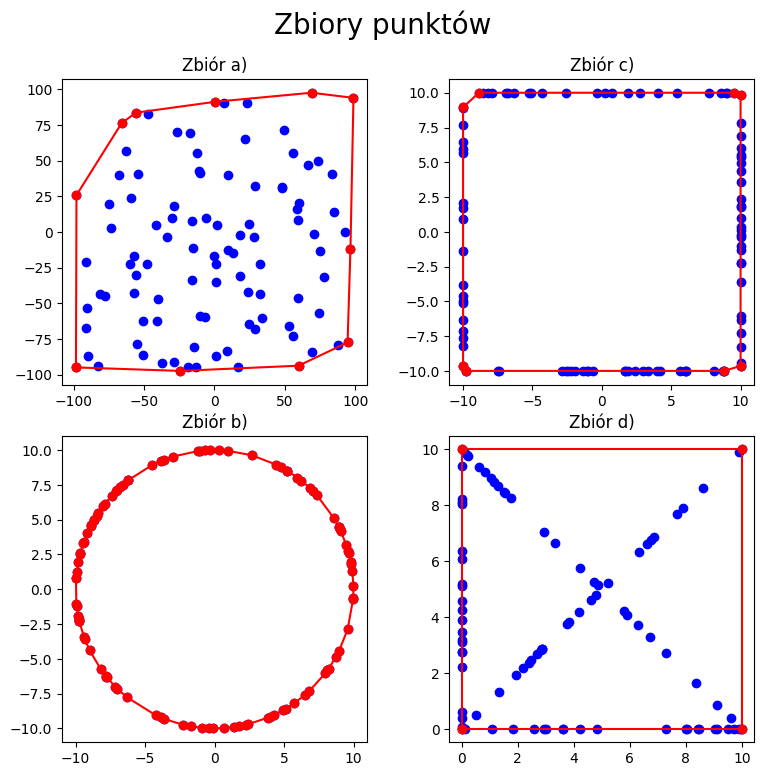

In [3]:
# dividing sets of points in respect to line a, b
from functools import reduce

eps = 10**(-10)

def length_2(a, b):
    return (a[0] - b[0])*(a[0] - b[0]) + (a[1] - b[1])*(a[1] - b[1])

def det(a, b, c):
    return (a[0] - c[0])*(b[1] - c[1]) - (b[0] - c[0])*(a[1] - c[1])

def orient(a, b, c):
    d = det(a, b, c)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0

def min_angle(a, b, c):

    if a[0] == b[0] and a[1] == b[1]:
        return c
    if a[0] == c[0] and a[1] == c[1]:
        return b
        
    d = det(a, b, c)

    if d == 0:
        if length_2(a, b) >= length_2(a, c):
            return b
        else:
            return c
    if d < 0:
        return b
    return c

# add visualize
def grahams(points, visualize=True):
    
    points = points.tolist()
    scenes = []

    # find a leftmost point with lowest y
    points.sort(key=lambda x:[x[0], x[1]])

    start = points.pop(0)

    def slope(p1, p2):
        if p1[0] == p2[0]:
            return float('inf')
        else:
            return 1.0*(p1[1]-p2[1])/(p1[0]-p2[0])

    points.sort(key=lambda p: length_2(start, p))
    points.sort(key=lambda p: slope(start, p))

    points = [start] + points

    hull = []
    hull.append(points[0])
    hull.append(points[1])
    hull.append(points[2])

    i = 3
    while i < len(points):            
        if orient(hull[-2], hull[-1], points[i]) == 0:
            hull.pop()
            hull.append(points[i])
            i = i + 1    
        elif orient(hull[-2], hull[-1], points[i]) == 1:
            hull.append(points[i])
            i = i + 1
        else:
            hull.pop()
        
        if visualize:
            scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')])) 

    if orient(hull[-2], hull[-1], hull[0]) == 0:
        hull.pop()
    
    # chceck if the second point added to hull isnt collinear with  1st and 3rd
    if orient(hull[0], hull[1], hull[2]) == 0:
        hull.pop(1)

    hull.append(hull[0])
    
    if visualize:
        scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')])) 

    return hull, scenes


def jarvis(points, visualize=True):
    
    points = points.tolist()

    start = min(points, key=lambda x: [x[1], x[0]])
    hull = [start]
    scenes = []
    
    while True:
        if visualize:
            scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')]))
            
        point = reduce(lambda a, b: min_angle(start, a, b), points)
        start = point
        hull.append(point)
        if hull[0] == point:
            break
            
    hull.append(hull[0])
    
    if visualize:
        scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')]))
    
    return hull, scenes

matplotlib.rcParams['figure.figsize'] = [8, 8]
figure, axis = plt.subplots(2, 2)
plt.axis("equal")

for i, data_set in enumerate(data):

    points = data_set
    convex_hull = grahams(points, False)[0]

    for point in points:
        axis[i%2, i//2].scatter(point[0], point[1], c="b")
    
    axis[i%2, i//2].plot(*zip(*convex_hull), "-ro")

figure.suptitle('Zbiory punktów', fontsize=20)
figure.tight_layout(pad=2)
axis[0, 0].set_title("Zbiór a)")
axis[0, 1].set_title("Zbiór c)")
axis[1, 0].set_title("Zbiór b)")
axis[1, 1].set_title("Zbiór d)")

# measuring time
cum_time = 0

# jarvis
for data_set in data:
    points = data_set
    st = time.time()
    convex_hull = jarvis(points, False)[0]
    cum_time += time.time() - st

print("Jarvis took: ", cum_time)
cum_time = 0

# grahams
for data_set in data:
    points = data_set
    st = time.time()
    convex_hull = grahams(points, False)[0]
    cum_time += time.time() - st

print("Grahams took: ", cum_time)


# save plot
# plt.savefig('images/line.png', dpi=500)
plt.show()

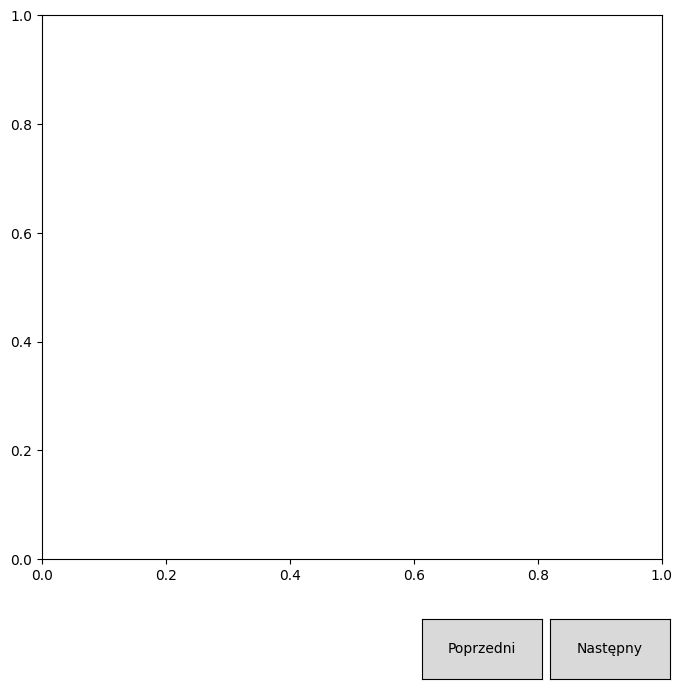

<Figure size 800x800 with 0 Axes>

In [4]:
viz = Plot(jarvis(data[1])[1])
viz.draw()

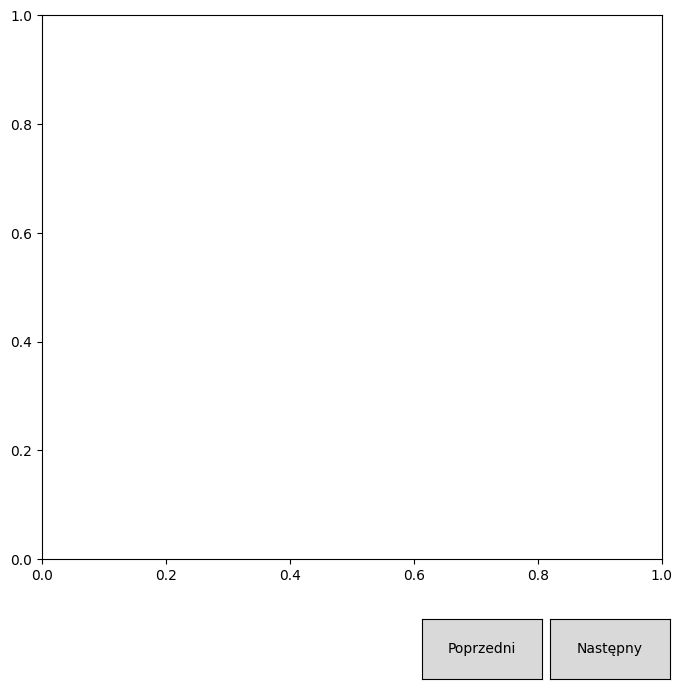

<Figure size 800x800 with 0 Axes>

In [5]:
viz = Plot(grahams(data[1])[1])
viz.draw()

0
1
2
3


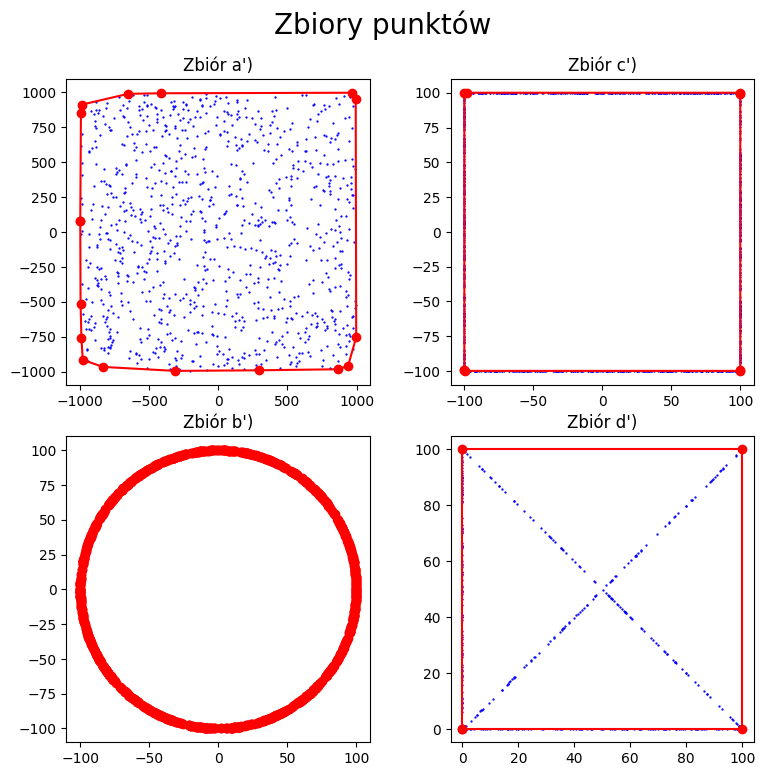

In [6]:
# VIZ for larger datasets

big_data = []

big_data.append(generate_set_a(-1000, 1000, 10 ** 3))
big_data.append(generate_set_b([0, 0], 100, 10 ** 3))
big_data.append(generate_set_c([-100, -100], [100, 100], 10 ** 3))
big_data.append(generate_set_d(100, 10**2, 10**2))

matplotlib.rcParams['figure.figsize'] = [8, 8]
figure, axis = plt.subplots(2, 2)
plt.axis("equal")

for i, data_set in enumerate(big_data):

    print(i)
    points = data_set
    convex_hull = grahams(points, False)[0]

    for point in points:
        axis[i%2, i//2].scatter(point[0], point[1], c="b", s=0.4)
    
    axis[i%2, i//2].plot(*zip(*convex_hull), "-ro")
    

figure.suptitle('Zbiory punktów', fontsize=20)
figure.tight_layout(pad=2)
axis[0, 0].set_title("Zbiór a')")
axis[0, 1].set_title("Zbiór c')")
axis[1, 0].set_title("Zbiór b')")
axis[1, 1].set_title("Zbiór d')")

# plt.savefig('images/big_sets.png', dpi=500)
plt.show()


In [7]:
# TESTING TIMES

# UNIFORM SPACE
DATA1 = generate_set_a(-1000, 1000, 10**2)
print("SET 1: " + 20*'-')

A = time.time()
grahams(DATA1, False)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis(DATA1, False)
print("Jarvis took:", time.time() - B)

# UNIFORM CIRCLE
DATA2 = generate_set_b([0, 0], 1000, 10**2)
print("SET 2: " + 20*'-')

A = time.time()
grahams(DATA2, False)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis(DATA2, False)
print("Jarvis took:", time.time() - B)

# RECNTAGLE UNIFORM SIDES
DATA3 = generate_set_c([-100, -100], [100, 100], 10**5)
print("SET 3: " + 20*'-')

A = time.time()
grahams(DATA3, False)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis(DATA3, False)
print("Jarvis took:", time.time() - B)

# SQUARE + DIAGONALS
DATA4 = generate_set_d(30, 10**5, 10**5)
print("SET 4: " + 20*'-')

A = time.time()
grahams(DATA4, False)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis(DATA4, False)
print("Jarvis took:", time.time() - B)

SET 1: --------------------
Grahams took: 0.0009953975677490234
Jarvis took: 0.0011494159698486328
SET 2: --------------------
Grahams took: 0.0
Jarvis took: 0.008541584014892578
SET 3: --------------------
Grahams took: 1.1914453506469727
Jarvis took: 0.9051129817962646
SET 4: --------------------
Grahams took: 4.298218727111816
Jarvis took: 2.2185425758361816
